In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as pyplot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
from datetime import datetime

In [3]:
# Load the dataset
df = pd.read_csv('Book.csv')

# Display initial info for insight
print(df.head())

   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0     16639  white    black   
1  5xyktca69fg561319    ca        5.0      9393  white    beige   
2  wba3c1c51ek116351    ca       45.0      1331   gray    black   
3  yv1612tb4f1310987    ca       41.0     14282  white    black   
4  wba6b2c57ed129731    ca       43.0      2641   gray    black   

                                   seller    mmr  sellingprice  \
0                 kia motors america  inc  20500         21500   
1                 kia motors america  

In [7]:
# Handling missing values
# Assuming numerical columns like 'Odometer', 'MMR', 'Sellingprice' might have missing values
df['odometer'].fillna(df['odometer'].median(), inplace=True)
df['mmr'].fillna(df['mmr'].mean(), inplace=True)
df['sellingprice'].fillna(df['sellingprice'].mean(), inplace=True)

In [12]:
from scipy import stats

# For categorical columns like 'Body', 'Transmission', 'Color', 'Interior', fill missing values with the mode
for column in ['body', 'transmission', 'color', 'interior']:
    df[column] = df[column].fillna(df[column].mode()[0])

# Removing outliers in 'Odometer', 'MMR', 'Sellingprice' using Z-score
numeric_cols = ['odometer', 'mmr', 'sellingprice']
df = df[(np.abs(stats.zscore(df[numeric_cols])) < 3).all(axis=1)]


In [13]:
# Categorizing 'Condition' into 'Good', 'Fair', 'Poor' based on 'Odometer' readings
odometer_quartiles = pd.qcut(df['odometer'], 3, labels=False)
df['Condition_Category'] = pd.cut(odometer_quartiles, bins=3, labels=['Good', 'Fair', 'Poor'])

# Ensure 'Transmission' and 'State' are of type 'category'
df['transmission'] = df['transmission'].astype('category')
df['state'] = df['state'].astype('category')

# Handling duplicate VINs by keeping the first occurrence
df.drop_duplicates(subset='vin', keep='first', inplace=True)

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Display final cleaned dataframe info and first few rows to verify changes
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                747 non-null    int64   
 1   make                745 non-null    object  
 2   model               745 non-null    object  
 3   trim                745 non-null    object  
 4   body                747 non-null    object  
 5   transmission        747 non-null    category
 6   vin                 747 non-null    object  
 7   state               747 non-null    category
 8   condition           714 non-null    float64 
 9   odometer            747 non-null    int64   
 10  color               747 non-null    object  
 11  interior            747 non-null    object  
 12  seller              747 non-null    object  
 13  mmr                 747 non-null    int64   
 14  sellingprice        747 non-null    int64   
 15  saledate            747 non-null    obje

In [14]:
print("Summary Statistics for Numerical Columns:")
print(df.describe())

# Summary for Categorical Columns
print("\nSummary for Categorical Columns:")
print(df.describe(include=['category']))

Summary Statistics for Numerical Columns:
              year   condition      odometer           mmr  sellingprice
count   747.000000  714.000000    747.000000    747.000000    747.000000
mean   2013.120482   33.222689  25894.303882  19934.170013  19300.203481
std       0.645833   15.124893  13333.611500   8193.757918   8556.313511
min    2012.000000    1.000000      1.000000   7050.000000   1000.000000
25%    2013.000000   29.000000  14675.000000  12900.000000  12275.000000
50%    2013.000000   39.000000  24498.000000  19000.000000  18801.000000
75%    2013.000000   44.000000  37161.000000  24100.000000  24750.000000
max    2015.000000   49.000000  63459.000000  46300.000000  46500.000000

Summary for Categorical Columns:
       transmission state Condition_Category
count           747   747                747
unique            2     1                  3
top       automatic    ca               Good
freq            728   747                249


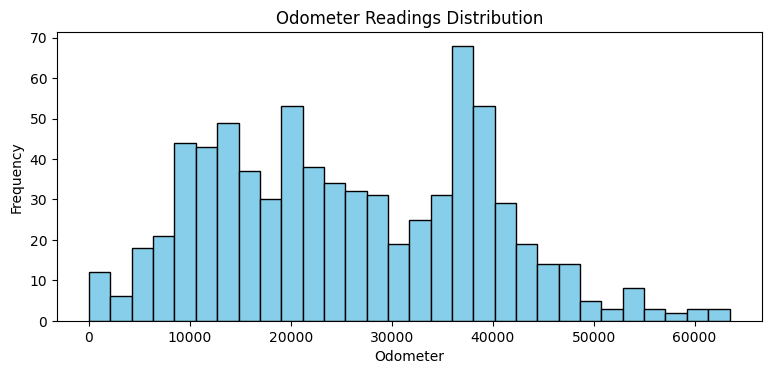

In [17]:

# Setting up the matplotlib figures
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

# Histogram of 'odometer' readings
plt.subplot(3, 2, 1)
plt.hist(df['odometer'], bins=30, color='skyblue', edgecolor='black')
plt.title('Odometer Readings Distribution')
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

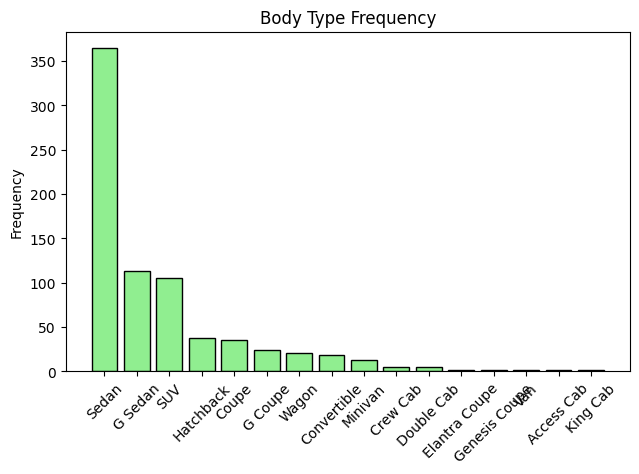

In [22]:
plt.figure(figsize=(16, 15))
# Bar chart of 'body' types
plt.subplot(3, 2, 2)
body_counts = df['body'].value_counts()
plt.bar(body_counts.index, body_counts.values, color='lightgreen', edgecolor='black')
plt.title('Body Type Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

Text(0, 0.5, 'Selling Price ($)')

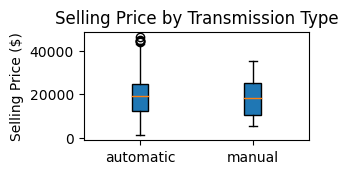

In [23]:
# Box plot of 'sellingprice' by 'transmission' type
plt.subplot(3, 2, 3)
transmissions = df['transmission'].unique()
prices_by_transmission = [df[df['transmission'] == t]['sellingprice'] for t in transmissions]
plt.boxplot(prices_by_transmission, patch_artist=True)
plt.title('Selling Price by Transmission Type')
plt.xticks(range(1, len(transmissions) + 1), transmissions)
plt.ylabel('Selling Price ($)')

Text(0, 0.5, 'Selling Price ($)')

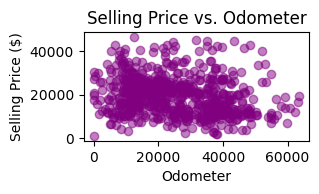

In [24]:
# Scatter plot of 'sellingprice' vs. 'odometer'
plt.subplot(3, 2, 4)
plt.scatter(df['odometer'], df['sellingprice'], alpha=0.5, color='purple')
plt.title('Selling Price vs. Odometer')
plt.xlabel('Odometer')
plt.ylabel('Selling Price ($)')

Text(0, 0.5, 'Frequency')

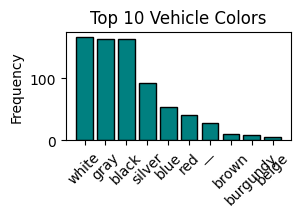

In [26]:
# Bar chart of 'color' distribution
plt.subplot(3, 2, 6)
color_counts = df['color'].value_counts().head(10)  # Top 10 colors for visibility
plt.bar(color_counts.index, color_counts.values, color='teal', edgecolor='black')
plt.title('Top 10 Vehicle Colors')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

In [28]:
plt.show()

In [32]:
# Mileage category based on 'odometer' readings
odometer_quartiles = pd.qcut(df['odometer'], 4, labels=False)
df['mileage_category'] = pd.cut(odometer_quartiles, bins=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Binary encoding for 'transmission' type
df['is_automatic'] = df['transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)

# State region based on 'state' (dummy example, replace with actual state-region mapping)
state_to_region = {
    'CA': 'West',
    'TX': 'South',
    'NY': 'East',
    # Add more mappings based on actual states in your dataset
}
df['region'] = df['state'].map(state_to_region)

# Price difference from MMR
df['price_diff_mmr'] = df['sellingprice'] - df['mmr']

# Log transformation of 'sellingprice' and 'mmr' for normalization
df['log_sellingprice'] = np.log(df['sellingprice'] + 1)  # Adding 1 to avoid log(0)
df['log_mmr'] = np.log(df['mmr'] + 1)


# Frequency encoding for 'color' and 'seller'
color_freq = df['color'].value_counts().to_dict()
df['color_freq'] = df['color'].map(color_freq)

seller_freq = df['seller'].value_counts().to_dict()
df['seller_freq'] = df['seller'].map(seller_freq)

# Display the enhanced dataframe
print(df.head())


   year    make     model        trim   body transmission                vin  \
0  2015     Kia   Sorento          LX    SUV    automatic  5xyktca69fg566472   
1  2015     Kia   Sorento          LX    SUV    automatic  5xyktca69fg561319   
2  2014     BMW  3 Series  328i SULEV  Sedan    automatic  wba3c1c51ek116351   
3  2015   Volvo       S60          T5  Sedan    automatic  yv1612tb4f1310987   
4  2015  Nissan    Altima       2.5 S  Sedan    automatic  1n4al3ap1fn326013   

  state  condition  odometer  ...                   saledate  \
0    ca        5.0     16639  ...  2014-12-16 12:30:00+08:00   
1    ca        5.0      9393  ...  2014-12-16 12:30:00+08:00   
2    ca       45.0      1331  ...  2015-01-15 04:30:00+08:00   
3    ca       41.0     14282  ...  2015-01-29 04:30:00+08:00   
4    ca        1.0      5554  ...  2014-12-30 12:00:00+08:00   

  Condition_Category mileage_category  is_automatic  region price_diff_mmr  \
0               Good           Medium             0     

In [34]:
# Correlation analysis
# Calculate Pearson correlation for numerical variables
correlation_matrix = df[['odometer', 'mmr', 'sellingprice']].corr(method='pearson')
print("Pearson Correlation Matrix:\n", correlation_matrix)

Pearson Correlation Matrix:
               odometer       mmr  sellingprice
odometer      1.000000 -0.310785     -0.255983
mmr          -0.310785  1.000000      0.948903
sellingprice -0.255983  0.948903      1.000000


In [35]:
# Hypothesis Testing: Comparing average selling prices by transmission type
# Null Hypothesis: There's no difference in average selling prices between automatic and manual transmission vehicles.
automatic_prices = df[df['transmission'] == 'Automatic']['sellingprice']
manual_prices = df[df['transmission'] == 'Manual']['sellingprice']
t_stat, p_value = stats.ttest_ind(automatic_prices, manual_prices, nan_policy='omit')
print(f"\nT-test between automatic and manual transmission selling prices:\nT-statistic: {t_stat}, P-value: {p_value}")


T-test between automatic and manual transmission selling prices:
T-statistic: nan, P-value: nan


In [36]:
# If p_value < 0.05, we reject the null hypothesis

# ANOVA test: Comparing selling prices across different body types
# Null Hypothesis: There are no differences in average selling prices across different body types.
anova_data = [df[df['body'] == body_type]['sellingprice'] for body_type in df['body'].unique()]
f_stat, p_value_anova = stats.f_oneway(*anova_data)
print(f"\nANOVA test for selling prices across body types:\nF-statistic: {f_stat}, P-value: {p_value_anova}")


ANOVA test for selling prices across body types:
F-statistic: 13.646660956320469, P-value: 9.221081577020003e-31


In [37]:
# If p_value_anova < 0.05, we reject the null hypothesis

# Chi-Square Test for Independence: Transmission type and body type
# Null Hypothesis: Transmission type and body type are independent.
contingency_table = pd.crosstab(df['transmission'], df['body'])
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-Square Test between transmission and body type:\nChi2 Statistic: {chi2_stat}, P-value: {p_value_chi2}")


Chi-Square Test between transmission and body type:
Chi2 Statistic: 17.025488585955998, P-value: 0.31734297952952967


In [38]:
# If p_value_chi2 < 0.05, we reject the null hypothesis indicating a relationship between transmission and body type

# Normality Test: Check if selling prices follow a normal distribution
# Null Hypothesis: The distribution of selling prices is normal.
k2_stat, p_value_normality = stats.normaltest(df['sellingprice'])
print(f"\nNormality Test for selling prices:\nK2 Statistic: {k2_stat}, P-value: {p_value_normality}")


Normality Test for selling prices:
K2 Statistic: 39.97541459843182, P-value: 2.0866471382427633e-09


In [39]:
# If p_value_normality < 0.05, the selling prices do not follow a normal distribution


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd



In [45]:
# Define categorical and numerical features again, ensuring all features are correctly identified
categorical_features = ['body', 'transmission', 'state', 'color', 'interior', 'seller']
numerical_features = ['condition', 'odometer', 'mmr']  # Update this based on your dataset's numerical columns

# Define the preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

# Define the model pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 2455.8139010949776
R² Score: 0.9070449231780582


In [46]:
import joblib

# Save the model to a file
joblib.dump(model_pipeline, 'final_model_pipeline.joblib')

print("Model saved successfully!")


Model saved successfully!


In [47]:
# Assuming y_pred are your final predictions and you want to compare them with the actual values
final_results = X_test.copy()
final_results['Actual Selling Price'] = y_test
final_results['Predicted Selling Price'] = y_pred

# Save the results to a new CSV file
final_results.to_csv('model_predictions.csv', index=False)

print("Results exported successfully!")


Results exported successfully!


In [48]:
print("Data analysis process completed successfully!")


Data analysis process completed successfully!
